In [1]:
import os
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from keras import Input, layers, Model, models
from keras.applications import *
from keras.callbacks import EarlyStopping
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
import keras_tuner as kt

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

%matplotlib inline

#### Dataset

In [2]:
DATA_DIR_NAME = 'data'

In [3]:
class_names = os.listdir(DATA_DIR_NAME)
class_names.sort()
num_classes = len(class_names)
class_names[:10]

['Abra',
 'Aerodactyl',
 'Alakazam',
 'Arbok',
 'Arcanine',
 'Articuno',
 'Beedrill',
 'Bellsprout',
 'Blastoise',
 'Bulbasaur']

In [4]:
image_paths = []
labels = []
for class_name in class_names:
    pokemon_dir = os.path.join(DATA_DIR_NAME, class_name)
    image_file_names = os.listdir(pokemon_dir)
    image_paths.extend(os.path.join(pokemon_dir, name) for name in image_file_names)
    labels.extend([class_name] * len(image_file_names))

df = pd.DataFrame({'filename': image_paths, 'class': labels})

In [5]:
df.value_counts('class')

class
Pikachu      286
Charizard    167
Venusaur     162
Sandslash    142
Gengar       140
            ... 
Poliwrath     61
Nidoking      60
Dratini       57
Nidoran♂      50
Nidoran♀      44
Name: count, Length: 151, dtype: int64

In [6]:
train_df, test_df = train_test_split(
    df,
    test_size=0.2,
    random_state=42,
    shuffle=True,
    stratify=df['class']  # Ensure all pokemon represented in each split
)
train_df, validation_df = train_test_split(
    train_df,
    test_size=0.25,
    random_state=42,
    shuffle=True,
    stratify=train_df['class']
)

### Utilities

In [7]:
def make_image_generator(dataframe, image_size, preprocessing_function, batch_size=64, **augmentations):
    datagen = ImageDataGenerator(
        preprocessing_function=preprocessing_function,
        **augmentations
    )
    return datagen.flow_from_dataframe(
        dataframe,
        target_size=image_size,
        class_mode='categorical',
        batch_size=batch_size
    )

In [8]:
def make_training_generators(image_size, preprocessing_function, batch_size=64, **augmentations):
    train_generator = make_image_generator(train_df, image_size, preprocessing_function, batch_size, **augmentations)
    validation_generator = make_image_generator(validation_df, image_size, preprocessing_function, batch_size)
    return train_generator, validation_generator

In [9]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=5,
    verbose=1,
    restore_best_weights=True
)

### Baseline Model

In [ ]:
train_generator, validation_generator = make_training_generators(
    image_size=(224, 224),
    preprocessing_function=vgg16.preprocess_input
)

In [ ]:
vgg16_base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
vgg16_base_model.trainable = False

vgg16_model = models.Sequential([
    vgg16_base_model,
    layers.Flatten(input_shape=vgg16_base_model.output_shape[1:]),
    layers.Dense(4096, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

vgg16_model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [ ]:
vgg16_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=30,
    callbacks=[early_stopping]
)

In [ ]:
vgg16_model.save('models/model_baseline.tf')

### Models

In [ ]:
train_generator, validation_generator = make_training_generators(
    image_size=(224, 224),
    preprocessing_function=resnet.preprocess_input
)

resnet_base_model = ResNet152(weights='imagenet', include_top=False)
resnet_base_model.trainable = False

resnet_model = models.Sequential([
    resnet_base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(num_classes, activation='softmax')
])

resnet_model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [ ]:
resnet_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10,
    callbacks=[early_stopping]
)

In [ ]:
train_generator, validation_generator = make_training_generators(
    image_size=(299, 299),
    preprocessing_function=inception_v3.preprocess_input
)

inception_v3_base_model = InceptionV3(weights='imagenet', include_top=False)
inception_v3_base_model.trainable = False

inception_v3_model = models.Sequential([
    inception_v3_base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(num_classes, activation='softmax')
])

inception_v3_model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [ ]:
inception_v3_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10,
    callbacks=[early_stopping]
)

In [ ]:
train_generator, validation_generator = make_training_generators(
    image_size=(299, 299),
    preprocessing_function=inception_resnet_v2.preprocess_input
)

inception_resnet_base_model = InceptionResNetV2(weights='imagenet', include_top=False)
inception_resnet_base_model.trainable = False

inception_resnet_model = models.Sequential([
    inception_resnet_base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(num_classes, activation='softmax')
])

inception_resnet_model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [ ]:
inception_resnet_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10,
    callbacks=[early_stopping]
)

In [21]:
train_generator, validation_generator = make_training_generators(
    image_size=(224, 224),
    preprocessing_function=densenet.preprocess_input
)

densenet_base_model = DenseNet201(weights='imagenet', include_top=False)
densenet_base_model.trainable = False

densenet_model = models.Sequential([
    densenet_base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(num_classes, activation='softmax')
])

densenet_model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

Found 8379 validated image filenames belonging to 151 classes.
Found 2793 validated image filenames belonging to 151 classes.


In [ ]:
densenet_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10,
    callbacks=[early_stopping]
)

In [ ]:
train_generator, validation_generator = make_training_generators(
    image_size=(224, 224),
    preprocessing_function=efficientnet.preprocess_input
)

efficientnet_base_model = EfficientNetB7(weights='imagenet', include_top=False)
efficientnet_base_model.trainable = False

efficientnet_model = models.Sequential([
    efficientnet_base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(num_classes, activation='softmax')
])

efficientnet_model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [ ]:
efficientnet_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10,
    callbacks=[early_stopping]
)

### Data Augmentation

In [10]:
# Without data augmentations
train_generator, validation_generator = make_training_generators(
    image_size=(224, 224),
    preprocessing_function=densenet.preprocess_input
)

densenet_base_model = DenseNet201(weights='imagenet', include_top=False)
densenet_base_model.trainable = False

densenet_model = models.Sequential([
    densenet_base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(num_classes, activation='softmax')
])

densenet_model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

Found 8379 validated image filenames belonging to 151 classes.
Found 2793 validated image filenames belonging to 151 classes.


<Axes: title={'center': 'Image counts for selected Pokémon before augmentation'}, xlabel='Pokémon', ylabel='Sample Count'>

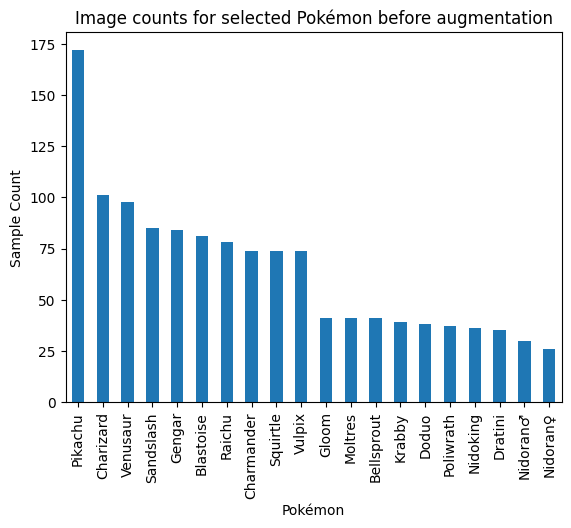

In [32]:
highest_counts = train_df.value_counts("class")[:10]
lowest_counts = train_df.value_counts("class")[-10:]
(pd.concat([highest_counts, lowest_counts])).plot(kind="bar", xlabel="Pokémon", ylabel="Sample Count", title="Image counts for selected Pokémon before augmentation")

In [ ]:
hist1 = densenet_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=20,
    callbacks=[early_stopping]
)

In [30]:
train_size = len(train_generator) * 64
epochs = 20

<Axes: title={'center': 'Rough image counts for selected Pokémon after augmentation'}, xlabel='Pokémon', ylabel='Sample Count'>

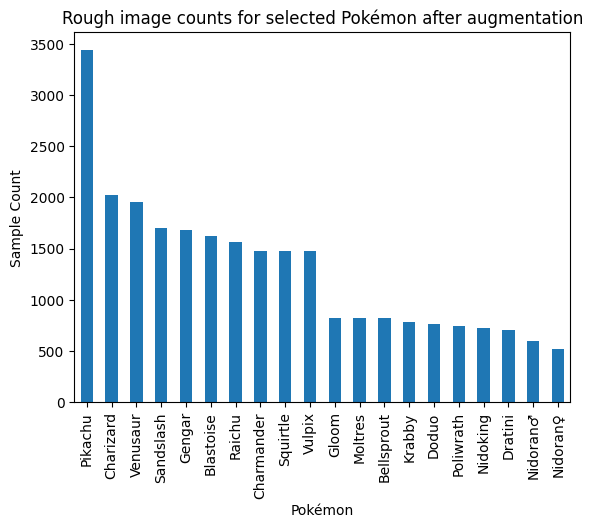

In [33]:
highest_counts = (train_df.value_counts("class") * epochs)[:10] #data is augmented with each epoch
lowest_counts = (train_df.value_counts("class") * epochs)[-10:]
(pd.concat([highest_counts, lowest_counts])).plot(kind="bar", xlabel="Pokémon", ylabel="Sample Count", title="Rough image counts for selected Pokémon after augmentation")

In [22]:
# With data augmentations
def make_augmented_dataset():
    return make_training_generators(
        image_size=(224, 224),
        preprocessing_function=densenet.preprocess_input,
        brightness_range = (0.8, 1.2),
        rotation_range=20,
        zoom_range=0.2,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest'
    )

train_generator, validation_generator = make_augmented_dataset()

densenet_base_model = DenseNet201(weights='imagenet', include_top=False)
densenet_base_model.trainable = False

densenet_model = models.Sequential([
    densenet_base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(num_classes, activation='softmax')
])

densenet_model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

Found 8379 validated image filenames belonging to 151 classes.
Found 2793 validated image filenames belonging to 151 classes.


In [23]:
hist2 = densenet_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=epochs,
    callbacks=[early_stopping],
    steps_per_epoch=train_size / 64
)

Epoch 1/20
 76/130 [================>.............] - ETA: 4:55 - loss: 4.5225 - accuracy: 0.1099

KeyboardInterrupt: 

In [ ]:
plt.figure()
plt.plot(hist1.history['loss'], label='Training Loss (Without Data Augmentation)', color='blue')
plt.plot(hist1.history['val_loss'], label='Validation Loss (Without Data Augmentation)', color='cyan')
plt.plot(hist2.history['loss'], label='Training Loss (With Data Augmentation)', color='red')
plt.plot(hist2.history['val_loss'], label='Validation Loss (With Data Augmentation)', color='pink')

plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Experimenting With Model Classification Head

In [ ]:
train_generator, validation_generator = make_augmented_dataset()
densenet_base_model = DenseNet201(weights='imagenet', include_top=False)
densenet_base_model.trainable = False

In [ ]:
def build_model(hp):
    dropout = hp.Choice('dropout', values=[0.0, 0.2, 0.4])
    model = models.Sequential()
    model.add(densenet_base_model)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(dropout))
    for i in range(hp.Int('num_layers', 0, 2)):
        model.add(layers.Dense(1024 // (2 ** i), activation='relu'))
        model.add(layers.Dropout(dropout))
    model.add(layers.Dense(num_classes, activation='softmax'))

    model.compile(
        optimizer="adam",
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [ ]:
#### HYPERPARAMETER TUNING #####
tuner = kt.tuners.GridSearch(
    build_model,
    objective='val_accuracy',
    directory='tuner',
    project_name='pokedex'
)

tuner.search_space_summary()

tuner.search(
    train_generator,
    validation_data=validation_generator,
    epochs=10,
    callbacks=[early_stopping]
)

tuner.results_summary()

### Fine Tuning

In [ ]:
train_generator, validation_generator = make_augmented_dataset()

densenet_base_model = DenseNet201(weights='imagenet', include_top=False)
densenet_base_model.trainable = False
inputs = Input(shape=(224, 224, 3))
x = densenet_base_model(inputs, training=False)  # Ensure batchnorm layers run in inference mode
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)
model = Model(inputs, outputs)

model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

history_train = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=50,
    callbacks=[early_stopping]
)

In [ ]:
model.save('models/model_untuned.tf')
with open('histories/model_training.pkl', 'wb') as file:
    pickle.dump(history_train.history, file)

In [ ]:
NUM_LAYERS_TO_UNFREEZE = 50

for layer in densenet_base_model.layers[-NUM_LAYERS_TO_UNFREEZE:]:
    layer.trainable = True

model.compile(
    loss='categorical_crossentropy',
    optimizer=RMSprop(learning_rate=1e-5),
    metrics=['accuracy']
)

history_fine = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=20,
    callbacks=[early_stopping]
)

In [ ]:
model.save('models/model_final.tf')
with open('histories/model_tuning.pkl', 'wb') as file:
    pickle.dump(history_fine.history, file)

#### Testing

In [ ]:
baseline_model = models.load_model('models/model_baseline.tf')
final_model = models.load_model('models/model_final.tf')

In [ ]:
test_generator = make_image_generator(
    test_df,
    image_size=(224, 224),
    preprocessing_function=densenet.preprocess_input
)

In [ ]:
results = model.evaluate(test_generator)

In [ ]:
predictions = model.predict(test_generator)
prediction_labels = np.argmax(predictions, axis=-1)

In [ ]:
print(classification_report(test_generator.classes, prediction_labels, target_names=class_names))

In [ ]:
confusion_matrix = confusion_matrix(test_generator.classes,prediction_labels)

In [ ]:
most_common_misclassifications = []

for r, row in enumerate(confusion_matrix):
    for c, val in enumerate(row):
        if r != c and val > 0:
            most_common_misclassifications.append((val, r, c))

most_common_misclassifications.sort(reverse=True)

print("Top Misclassifications:")
for count, actual, pred in most_common_misclassifications[:30]:
    print(f"True class {class_names[actual]} misclassified as {class_names[pred]}: Count {count}")